In [1]:
import warnings

import arviz as az
import bambi as bmb
import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from graphviz import Digraph
from IPython.display import display

# Funzione per mostrare i grafici in Jupyter
def show_graph(graph):
    display(graph)

warnings.filterwarnings("ignore")

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "regr_causal_inference"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

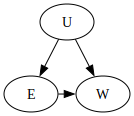

In [3]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("E")
    s.node("W")

f.node("U")
f.edge("U", "E")
f.edge("U", "W")
f.edge("E", "W")

f

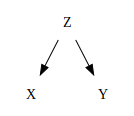

In [4]:
# Biforcazione: X <- Z -> Y
fork = Digraph(comment='Forchetta')
fork.node('X', 'X', shape='plaintext')
fork.node('Y', 'Y', shape='plaintext')
fork.node('Z', 'Z', shape='plaintext')
fork.edge('Z', 'X')
fork.edge('Z', 'Y')
show_graph(fork)

In [5]:
n = 1000
Z = np.random.normal(0, 1, n)
X = 0.5 * Z + np.random.normal(0, 1, n)
Y = 0.8 * Z + np.random.normal(0, 1, n)

df = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

# Modello senza controllo per Z
mod1 = bmb.Model('Y ~ X', df)
results1 = mod1.fit()
az.summary(results1, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Y_sigma, Intercept, X]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.03,0.04,-0.05,0.10,0.0,0.0,6319.65,3113.15,1.0
X,0.33,0.04,0.26,0.40,0.0,0.0,7181.30,3138.17,1.0
Y_sigma,1.27,0.03,1.22,1.32,0.0,0.0,6769.22,3370.82,1.0


In [6]:
# Modello con controllo per Z
mod2 = bmb.Model('Y ~ X + Z', df)
results2 = mod2.fit()
az.summary(results2, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Y_sigma, Intercept, X, Z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.04,0.03,-0.03,0.10,0.0,0.0,5527.77,3142.76,1.0
X,0.01,0.03,-0.06,0.07,0.0,0.0,3641.37,3072.68,1.0
Y_sigma,1.06,0.02,1.02,1.11,0.0,0.0,5863.47,3207.43,1.0
Z,0.79,0.04,0.72,0.86,0.0,0.0,3651.68,3359.35,1.0


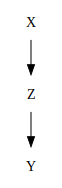

In [7]:
# Catena: X -> Z -> Y
pipe = Digraph(comment='Tubo')
pipe.node('X', 'X', shape='plaintext')
pipe.node('Y', 'Y', shape='plaintext')
pipe.node('Z', 'Z', shape='plaintext')
pipe.edge('X', 'Z')
pipe.edge('Z', 'Y')
show_graph(pipe)

In [8]:
X = np.random.normal(0, 1, n)
Z = 5 * X + np.random.normal(0, 1, n)
Y = 3 * Z + np.random.normal(0, 1, n)

df = pd.DataFrame({'X': X, 'Z': Z, 'Y': Y})

# Modello senza controllo per Z
mod1 = bmb.Model('Y ~ X', df)
results1 = mod1.fit()
az.summary(results1, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Y_sigma, Intercept, X]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.10,0.10,-0.29,0.07,0.0,0.0,7309.68,3443.40,1.0
X,14.88,0.10,14.69,15.07,0.0,0.0,6354.35,3250.28,1.0
Y_sigma,3.13,0.07,3.00,3.26,0.0,0.0,6426.58,3125.25,1.0


In [9]:
# Modello con controllo per Z
mod2 = bmb.Model('Y ~ X + Z', df)
results2 = mod2.fit()
az.summary(results2, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Y_sigma, Intercept, X, Z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.05,0.03,-0.11,0.01,0.0,0.0,3223.77,2734.25,1.0
X,0.05,0.16,-0.25,0.34,0.0,0.0,1651.88,1982.11,1.0
Y_sigma,0.98,0.02,0.94,1.02,0.0,0.0,2278.20,2012.16,1.0
Z,2.99,0.03,2.94,3.05,0.0,0.0,1686.84,2055.07,1.0


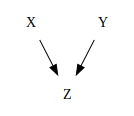

In [10]:
# Collider: X -> Z <- Y
collider = Digraph(comment='Collider')
collider.node('X', 'X', shape='plaintext')
collider.node('Y', 'Y', shape='plaintext')
collider.node('Z', 'Z', shape='plaintext')
collider.edge('X', 'Z')
collider.edge('Y', 'Z')
show_graph(collider)

In [11]:
# Numero di proposte da finanziare
N = 200
# Proporzione da selezionare
p = 0.1
# Rilevanza non correlata
nw = np.random.randn(N)
# Affidabilità non correlata
tw = np.random.randn(N)
correlation = np.corrcoef(tw, nw)[0, 1]
print(correlation)

-0.05795246951224541


In [12]:
# Punteggio totale
s = nw + tw
# Soglia per il 10% migliore
q = np.quantile(s, 1 - p)
# Selezionati
selected = s >= q
# Correlazione tra affidabilità e rilevanza nei selezionati
correlation = np.corrcoef(tw[selected], nw[selected])[0, 1]
print(correlation)

-0.578798583641946


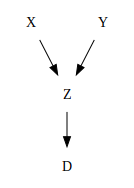

In [13]:
# Discendente: X -> Z <- Y; Z -> D
descendant = Digraph(comment='Discendente')
descendant.node('X', 'X', shape='plaintext')
descendant.node('Y', 'Y', shape='plaintext')
descendant.node('Z', 'Z', shape='plaintext')
descendant.node('D', 'D', shape='plaintext')
descendant.edge('X', 'Z')
descendant.edge('Y', 'Z')
descendant.edge('Z', 'D')
show_graph(descendant)

In [14]:
I = np.random.normal(100, 15, n)
T = 200 - I + np.random.normal(0, 1, n)
S = 0.5 * I + 0.1 * T + np.random.normal(0, 1, n)
D = 0.7 * S + np.random.normal(0, 1, n)

df = pd.DataFrame({'I': I, 'T': T, 'S': S, 'D': D})

# Modello senza controllo per D
mod1 = bmb.Model('S ~ T', df)
results1 = mod1.fit()
az.summary(results1, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [S_sigma, Intercept, T]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,99.83,0.24,99.38,100.28,0.0,0.0,5721.97,2826.07,1.0
S_sigma,1.11,0.02,1.06,1.15,0.0,0.0,6743.68,3476.02,1.0
T,-0.40,0.00,-0.40,-0.39,0.0,0.0,5827.65,2753.16,1.0


In [15]:
# Modello con controllo per D
mod2 = bmb.Model('S ~ T + D', df)
results2 = mod2.fit()
az.summary(results2, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [S_sigma, Intercept, T, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,0.55,0.02,0.51,0.59,0.00,0.00,2119.41,1939.28,1.01
Intercept,61.25,1.64,58.30,64.32,0.04,0.03,2092.23,1835.08,1.00
S_sigma,0.88,0.02,0.84,0.91,0.00,0.00,3192.86,2340.90,1.00
T,-0.24,0.01,-0.26,-0.23,0.00,0.00,2092.32,1825.33,1.00


In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

networkx   : 3.3
numpy      : 1.26.4
graphviz   : 0.20.3
statsmodels: 0.14.2
bambi      : 0.13.0
pandas     : 2.2.2
seaborn    : 0.13.2
arviz      : 0.18.0
matplotlib : 3.8.4

Watermark: 2.4.3

